In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import sys
import torch
from torch import nn
from omegaconf import OmegaConf, open_dict
from sklearn.metrics import auc


sys.path.append('../')
from data_utils import get_eval_data, get_subset
from model.unet import get_unet
from model.dae import get_daes
from utils import (
    UMapGenerator, 
)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [3]:
cfg = OmegaConf.load('../configs/basic_config.yaml')

OmegaConf.update(cfg, "run.data_key", 'heart')
OmegaConf.update(cfg, "run.iteration", 0)

dae_cfg = OmegaConf.load('../configs/dae/unetDAE_config.yaml')

OmegaConf.update(cfg, "dae", dae_cfg)

In [4]:
print(OmegaConf.to_yaml(cfg))  

debug: false
wandb:
  log: true
  project: MICCAI2023-extension
fs:
  root: ../../
data:
  brain:
    data_path: data/conp-dataset/projects/calgary-campinas/CC359/Reconstructed/
  heart:
    data_path: data/mnm/
unet:
  brain:
    pre: calgary_unet
    n_chans_in: 1
    n_filters_init: 8
    n_chans_out: 1
    training:
      save_loc: pre-trained
      train_site: 6
      augment: true
      validation: true
      batch_size: 32
      epochs: 250
      patience: 4
      lr: 0.001
  heart:
    pre: acdc_unet8_
    n_chans_in: 1
    n_filters_init: 8
    n_chans_out: 4
    training:
      save_loc: pre-trained
      augment: true
      validation: true
      batch_size: 32
      num_batches_per_epoch: 250
      num_val_batches_per_epoch: 50
      epochs: 250
      patience: 4
      lr: 0.001
run:
  data_key: heart
  iteration: 0
dae:
  model: unet
  name: unet_up3_res3
  arch:
    shortcut0:
      channel: 8
      num_res_units: 3
    shortcut1:
      channel: 16
      num_res_units: 3


In [5]:
data = get_eval_data(
    train_set=False,
    val_set=False,
    test_sets=['A'],
    cfg=cfg
)


loading dataset
loading all case properties


In [6]:
data

{'A': <dataset.MNMDataset at 0x7f5a7914a9a0>}

In [7]:
# get segmentation model
unet, state_dict = get_unet(
    cfg=cfg, 
    return_state_dict=True
)
unet.load_state_dict(state_dict)

if cfg.run.data_key == 'brain':
    data_small = {}
    for key in data:
        data_small[f'{key}_small'] = get_subset(
            dataset=data[key], 
            model=unet.cuda(),
            criterion=nn.BCEWithLogitsLoss(reduction='none'),
            n_cases=256,
            fraction=0.1,
            batch_size=32,
            verbose=True
        )
    data = {**data, **data_small}


# get denoising models
model, state_dict = get_daes(
    unet=unet,
    cfg=cfg, 
    return_state_dict=True
)
model.load_state_dict(state_dict)

Disabling layer shortcut0.
Disabling layer shortcut1.
Disabling layer shortcut2.


<All keys matched successfully>

In [26]:
from torch import nn, Tensor
import torch.functional as F

class UMapGenerator(nn.Module):
    """
    Calculates uncertainty maps from UNets in different ways.
    
    PyTorch Module to generate uncertainty maps from
    * VAE samples
    * Entropy in drop out samples
    * Entropy in model outputs
    """
    
    def __init__(
        self,
        method: str,  # 'ae'
        net_out: str,  # 'mms' or 'calgary'
    ):
        super().__init__()
        self.method  = method
        self.net_out = net_out
        self.m       = nn.Softmax(dim=1) if net_out=='heart' else nn.Sigmoid()
        self.ce      = nn.CrossEntropyLoss(reduction='none') if net_out=='heart' else nn.BCEWithLogitsLoss(reduction='none')
    
    @torch.no_grad()
    def forward(self, x: Tensor, batch_size: int) -> Tensor:
        
        if self.method == 'none':
            return None
        
        x = x.detach()
        
        #################################
        ### experimental / M&M only   ###
        #################################
        
        if self.method == 'cross_entropy':
            umap = self.ce(x[:batch_size], self.m(x[batch_size:]))
            # umap = umap.mean(dim=1, keepdims=True)
            
        elif self.method == 'entropy':          
            x_prob = self.m(x[:batch_size])
            umap = torch.distributions.Categorical(x_prob.permute(0,2,3,1)).entropy()

        elif self.method == 'kl_divergence':
            x_in = F.log_softmax(x[:batch_size], dim=1)
            umap = self.kl(x_in, self.m(x[batch_size:]))
            umap = umap.sum(dim=(1), keepdims=True)
            
        elif self.method == 'mse':
            x      = self.m(x)
            x     -= x.min(dim=1, keepdims=True).values
            x     /= x.sum(dim=1, keepdims=True)
            umap   = torch.pow(x[:batch_size] - x[batch_size:], 2).mean(0, keepdim=True)
            umap   = umap.mean(dim=1, keepdims=True)            
            
        #################################
        ###   old umaps from MICCAI   ###
        #################################
        
        if self.method == 'ae':
            if self.net_out == 'mms':                
                umap = self.ce(x[:1], self.m(x[1:]))
                #umap = umap.mean(dim=(0, 1), keepdims=True)
                #print(umap.shape)
                umap = umap.mean(dim=0, keepdims=True)
#                 x      = self.m(x)
#                 x     -= x.min(dim=1, keepdims=True).values
#                 x     /= x.sum(dim=1, keepdims=True)
#                 umap   = torch.pow(x[:1] - x[1:], 2).mean(0, keepdim=True)
#                 umap   = umap.mean(dim=1, keepdims=True)
                
            elif self.net_out == 'calgary':
                x    = torch.sigmoid(x)
                umap = torch.pow(x[:1] - x[1:], 2).mean(0, keepdim=True)
#                 umap = self.ce(x[:1] - self.m(x[1:]))
#                 umap = 
                
                
        elif self.method == 'entropy':          

            if self.net_out == 'mms':
                #print('x', x.shape)
                #x_argmax  = torch.argmax(x, dim=1)
                #print('2',x_argmax.shape)
                #x_one_hot = F.one_hot(x_argmax, num_classes=4).permute(0,3,1,2).float()
                #print('3',x_one_hot.shape)
                x_softmax = F.softmax(x, dim=1)
                #print('soft',x_softmax.shape)
                #x_mean    = x_one_hot.mean(dim=0, keepdims=True)
                x_mean    = x_softmax.mean(dim=0, keepdims=True)
                #print('4',x_mean.shape)
                umap = torch.distributions.Categorical(x_mean.permute(0,2,3,1)).entropy()
                #print('5',umap.shape)
                #umap      = - x_mean * torch.log(x_mean)
                #umap      = umap.sum(dim=1, keepdims=True)

            elif self.net_out == 'calgary':
                x_probs = torch.sigmoid(x[1:])
                x_mean  = x_probs.mean(dim=0, keepdims=True)
                umap    = - x_mean * torch.log(x_mean) - (1-x_mean) * torch.log(1-x_mean)
                
        elif self.method == 'probs':
            if self.net_out == 'mms':
                x_probs = F.softmax(x, dim=1)
                umap = torch.distributions.Categorical(x_probs.permute(0,2,3,1)).entropy()
                #umap    = - x_probs * torch.log(x_probs)
                #umap    = umap.sum(dim=1, keepdims=True)
                
            elif self.net_out == 'calgary':
                x_probs = torch.sigmoid(x)
                #print(x_probs.min(), x_probs.max())
                #umap = torch.distributions.Categorical(x_probs.permute(0,2,3,1)).entropy()
                umap    = - x_probs * torch.log(x_probs+1e-6) - (1-x_probs) * torch.log(1-x_probs+1e-6)
        
        #print(umap.shape)
        return umap

In [28]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from typing import Union
from torchmetrics.classification import BinaryPrecisionRecallCurve
import torcheval

@torch.no_grad()
def get_precision_recall(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    dae: bool,
    umap: str,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    if dae == True:
        # Remove trainiung hooks, add evaluation hooks
        model.remove_all_hooks()        
        model.hook_inference_transformations(model.transformations, n_samples=1)
        # Put model in evaluation state
        model.to(device[0])
        model.eval()
        model.freeze_seg_model()

    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        gt = batch['target'].to(device[0])
        gt[gt == -1] = 0
        output = model(input_)

        if net_out == 'brain':
            segmap = (torch.sigmoid(output[:batch_size]) > 0.5) * 1
            errmap = (gt != segmap).float()
        elif net_out == 'heart':
            segmap = torch.argmax(output[:batch_size], dim=1, keepdims=True)
            print(segmap.shape, gt.shape)
            errmap = (gt != segmap).float()
        # print(umap_generator(output, batch_size=batch_size).cpu().shape)
        umaps.append(umap_generator(output, batch_size=batch_size).cpu())
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten().half()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).cuda()
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])
    p_sampled, r_sampled = (
        pr[0][1::len(pr[0])//100], 
        pr[1][1::len(pr[1])//100]
    )
    p_sampled[-1], r_sampled[-1] = 1, 0

    return p_sampled, r_sampled, pr_auc



In [29]:
p_sampled, r_sampled, pr_auc = get_precision_recall(
    model=model,
    dataset=data['A'],
    net_out='heart',
    dae=True,
    umap='cross_entropy',
    device=['cuda:0', 'cuda:0'],
)

torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256]) torch.Size

0.39688459038734436


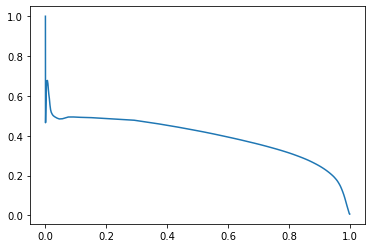

In [30]:
import matplotlib.pyplot as plt
plt.plot(r_sampled, p_sampled)
print(pr_auc)

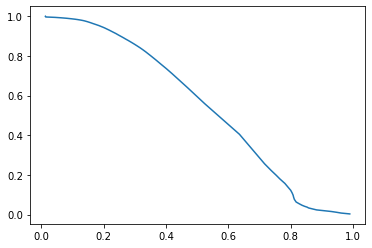

In [158]:
r = torch.stack([result[0], result[1]], dim=0)
r_down = torch.nn.functional.interpolate(r[None,  :], size=100, mode='linear')

plt.plot(r_down[0,0], r_down[0,1])

In [157]:
r_down.shape

torch.Size([1, 2, 100])

In [143]:
result[0][None, None,  :].shape

torch.Size([1, 1, 14483])

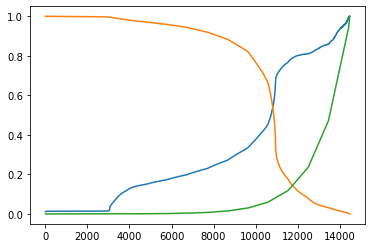

In [133]:
plt.plot(result[0])
plt.plot(result[1])
plt.plot(result[2])

In [13]:
tmp = result.compute()

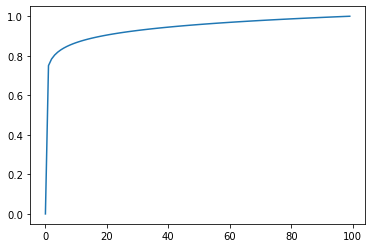

In [44]:
plt.plot(torch.linspace(0, 1, 100)**(1/16))

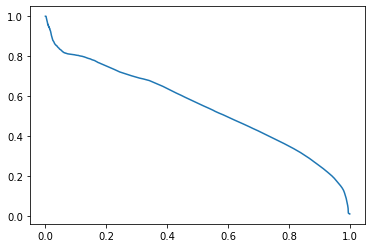

In [160]:
import matplotlib.pyplot as plt
plt.plot(result[1][1::10], result[0][1::10])

# torcheval.metrics.functional.auc(tmp[1], tmp[0], reorder=True)

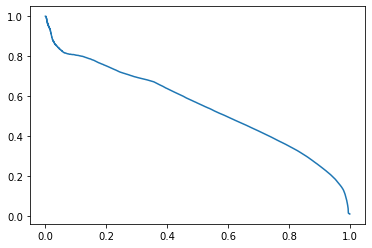

In [161]:
import matplotlib.pyplot as plt
plt.plot(result[1], result[0])

In [125]:
torcheval.metrics.functional.auc(result[1], result[0], reorder=True)


tensor([0.5495])

In [14]:
from torcheval import metrics

In [ ]:
metrics.BinaryAUPRC

torcheval.metrics.classification.auprc.BinaryAUPRC

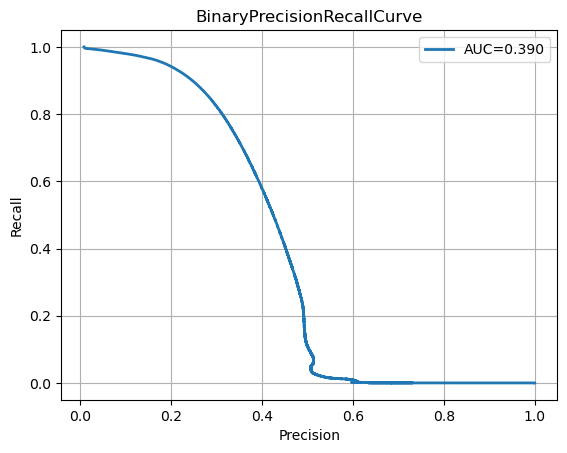

In [ ]:
tmp = result.plot(score=True)

In [76]:
result[1].shape

torch.Size([16236955])

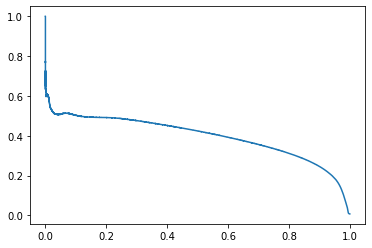

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result[1].cpu(), result[0].cpu())

In [ ]:
import torchmetrics
auc = torchmetrics.AUC()

AttributeError: module 'torchmetrics' has no attribute 'AUC'

val: 0.418
A: 0.397
B: 0.363
C: 0.334
D: 0.432


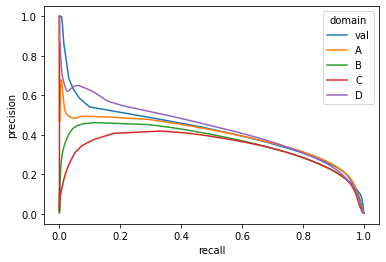

In [3]:
import pandas as pd
import seaborn as sns

dfs = []

# for domain in [1,2,3,4,5,'val']:

#     dfs.append(pd.read_csv(f'../../results-tmp/brain_calgary_unet_res_3_{domain}_subset.csv'))
    
# df = pd.concat(dfs)

data_key = 'heart'


# dfs.appennd(pd.read_csv(f'../../results-tmp/{data_key}_unet_all_res3_0.csv'))
dfs.append(pd.read_csv(f'../../results-tmp/{data_key}_unet_up3_res3_0.csv'))
df = pd.concat(dfs)

sns.lineplot(data=df, x='recall', y='precision', hue='domain')

for domain in df['domain'].unique():
    print(f"{domain}: {df[df['domain']==f'{domain}']['pr_auc'].mean():.3f}")

In [12]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

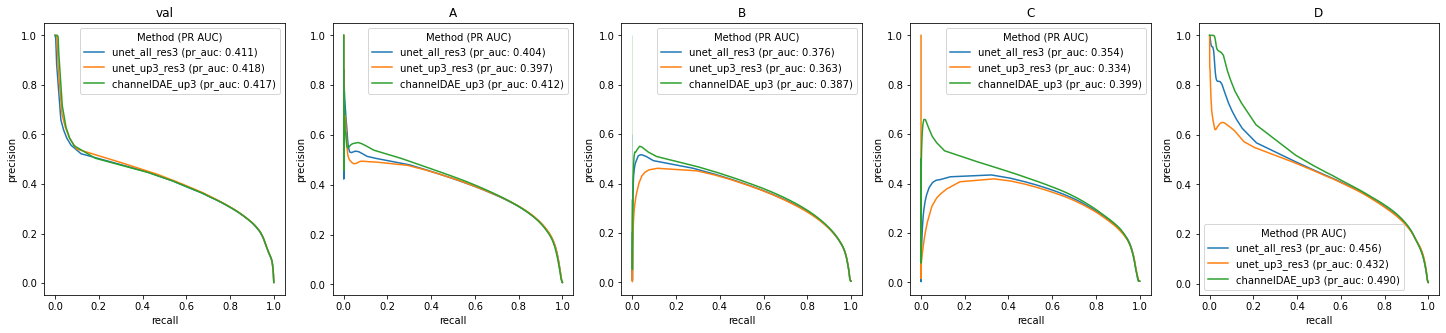

In [61]:
dfs = []

data_key = 'heart'
methods = ['unet_all_res3', 'unet_up3_res3', 'channelDAE_up3']

for method in methods:
    tmp = pd.read_csv(f'../../results-tmp/{data_key}_{method}_0.csv')
    tmp.method = method
    dfs.append(tmp)
# dfs.append(pd.read_csv(f'../../results-tmp/{data_key}_unet_up3_res3_0.csv'))
df = pd.concat(dfs)

# Map methods to their pr_auc values
method_to_pr_auc = df.groupby(['method', 'domain'])['pr_auc'].first().to_dict()

# Add pr_auc to method names in the dataframe
df['method_pr_auc'] = df.apply(
    lambda x: f"{x['method']} (pr_auc: {method_to_pr_auc[(x['method'], x['domain'])]:.3f})", 
    axis=1
)


domains = df['domain'].unique()

fig, axes = plt.subplots(1, len(domains), figsize=(25, 5))

for i, domain in enumerate(domains):
    axes[i].set_title(f'{domain}')
    sns.lineplot(
        data=df[df['domain']==f'{domain}'],
        x='recall', 
        y='precision', 
        hue='method_pr_auc',
        ax=axes[i]
    )
    axes[i].legend(title='Method (PR AUC)')

plt.savefig('pr_auc_heart.png', bbox_inches='tight', dpi=400, transparent=False)
# for domain in df['domain'].unique():
#     print(f"{domain}: {df[df['domain']==f'{domain}']['pr_auc'].mean():.3f}")

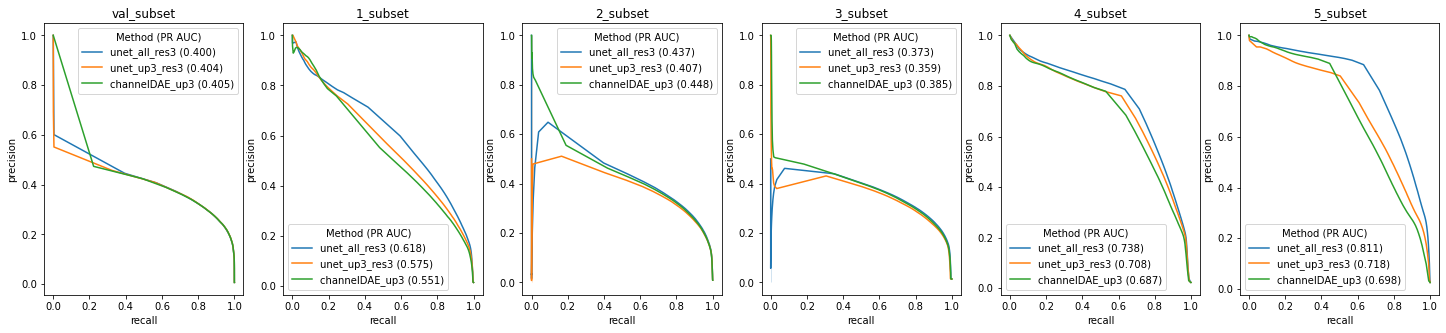

In [64]:
dfs = []

data_key = 'brain'
methods = ['unet_all_res3', 'unet_up3_res3', 'channelDAE_up3']

for method in methods:
    tmp = pd.read_csv(f'../../results-tmp/{data_key}_{method}_0.csv')
    tmp.method = method
    dfs.append(tmp)
# dfs.append(pd.read_csv(f'../../results-tmp/{data_key}_unet_up3_res3_0.csv'))
df = pd.concat(dfs)

# Map methods to their pr_auc values
method_to_pr_auc = df.groupby(['method', 'domain'])['pr_auc'].first().to_dict()

# Add pr_auc to method names in the dataframe
df['method_pr_auc'] = df.apply(
    lambda x: f"{x['method']} ({method_to_pr_auc[(x['method'], x['domain'])]:.3f})", 
    axis=1
)


domains = df['domain'].unique()

fig, axes = plt.subplots(1, len(domains), figsize=(25, 5))

for i, domain in enumerate(domains):
    axes[i].set_title(f'{domain}')
    sns.lineplot(
        data=df[df['domain']==f'{domain}'],
        x='recall', 
        y='precision', 
        hue='method_pr_auc',
        ax=axes[i]
    )
    axes[i].legend(title='Method (PR AUC)')

# plt.savefig('pr_curve_brain.png', bbox_inches='tight', dpi=400, transparent=False)

In [16]:
pd.read_csv(f'../../results-tmp/brain_unet_up3_res3_0.csv')

,Unnamed: 0,precision,recall,pr_auc,data_key,run,domain,method
0,0,1.000000,0.000000,0.403994,brain,0,val_subset,unet_up3_res3
1,1,0.007341,1.000000,0.403994,brain,0,val_subset,unet_up3_res3
2,2,0.007383,1.000000,0.403994,brain,0,val_subset,unet_up3_res3
3,3,0.007408,1.000000,0.403994,brain,0,val_subset,unet_up3_res3
4,4,0.007428,1.000000,0.403994,brain,0,val_subset,unet_up3_res3
...,...,...,...,...,...,...,...,...
601,96,0.873875,0.144948,0.762697,brain,0,5_subset,unet_up3_res3
602,97,0.863783,0.124936,0.762697,brain,0,5_subset,unet_up3_res3
603,98,0.851448,0.104302,0.762697,brain,0,5_subset,unet_up3_res3
604,99,0.827502,0.076528,0.762697,brain,0,5_subset,unet_up3_res3


In [8]:
df.method.unique()

array(['dae'], dtype=object)